# Setup


In [94]:
import warnings
warnings.filterwarnings('ignore')


import os
os.environ["DGLBACKEND"] = "pytorch"

import pandas as pd
import numpy as np

##--Modelling--##
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import NeighborSampler, DataLoader



# 0️⃣ Utilities Functions

In [95]:
def label_encoder(df:pd.DataFrame, column_1:str, column_2:str, label_col_name:str):
    '''Generate the labels for the specify column for the dataframe'''
    a = set(df[column_1].unique())
    b = set(df[column_2].unique())
    label_table = a.union(b)
    label_table = pd.DataFrame(label_table,columns=[label_col_name])
    label_encoder = LabelEncoder()
    label_table['label'] = label_encoder.fit_transform(label_table[label_col_name])
    _mapping = dict(zip(label_table[label_col_name], label_table['label']))
    df[column_1] = df[column_1].map(_mapping)
    df[column_2] = df[column_2].map(_mapping)
    return df, label_table

def get_node_label(df:pd.DataFrame):
    '''Return label 1 if both the payer and receiver account are involved in a laundering transaction'''
    laundering_records = df[df['is_laundering']==1]
    from_accounts = set(laundering_records['from_account'])
    to_accounts = set(laundering_records['to_account'])
    laundering_accounts = pd.DataFrame()
    laundering_accounts['account'] = list(from_accounts | to_accounts) 
    laundering_accounts['is_laundering'] = 1
    return laundering_accounts
    


# 1️⃣ Graph Construction

The graph will use all unique account numbers (Both the paying end and receving end) as node, with the transaction between the account as the edges of the graph.

The following pre-processing steps has been prior the construction of the graph:
1. Create account IDs for each account by prefix each account number with the bank code
2. Create labels fro account (now encode with bank code), currency and payment format

In [96]:
trans_df = pd.read_parquet("../00_data/trans_df.parquet")
DTYPE = np.float32
print("Raw Sample Data:")
display(trans_df.head(1))
tmp = trans_df['is_laundering'].value_counts()
print(f"Size of the Dataset: {trans_df.shape}")
print(f"Number of non-laundering samples: {tmp[0]}( {round(tmp[0]/tmp.sum()*100, 3)}% ) \nNumber of laundering samples: {tmp[1]} ( {round(tmp[1]/tmp.sum()*100, 3)}% )")


##Create unique ID account prefix with bank
trans_df['from_account'] = trans_df['from_bank'] + "_" + trans_df['from_account']
trans_df['to_account'] = trans_df['to_bank'] + "_" + trans_df['to_account']

##--Label encoding for account number--##
trans_df, account_label_table = label_encoder(trans_df, "from_account", "to_account", 'account')
trans_df, currency_label_table = label_encoder(trans_df, "payment_currency", "receiving_currency", 'currency')

##--Label encoding for payment_format--##
payment_format_label_encoder = LabelEncoder()
trans_df['payment_format'] = payment_format_label_encoder.fit_transform( trans_df['payment_format'] )
print("/nSample  Data after Transformation")

##--PreProcesss Timestamp with min max normalization--##
trans_df['timestamp'] = pd.to_datetime(trans_df['timestamp'])
trans_df['timestamp'] = trans_df['timestamp'].apply(lambda x: x.value)
trans_df['timestamp'] = (trans_df['timestamp']-trans_df['timestamp'].min())/(trans_df['timestamp'].max()-trans_df['timestamp'].min())


display(trans_df.head())


Raw Sample Data:


,transaction_id,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,0,2022-09-01 00:20:00,010,8000EBD30,010,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0


Size of the Dataset: (5078345, 12)
Number of non-laundering samples: 5073168( 99.898% ) 
Number of laundering samples: 5177 ( 0.102% )
/nSample  Data after Transformation


,transaction_id,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,0,0.000786,010,132152,010,132152,3697.34,12,3697.34,12,5,0
1,1,0.000786,03208,417156,001,39897,0.01,12,0.01,12,3,0
2,2,0.000000,03209,417458,03209,417458,14675.57,12,14675.57,12,5,0
3,3,0.000079,012,192342,012,192342,2806.97,12,2806.97,12,5,0
4,4,0.000236,010,132160,010,132160,36682.97,12,36682.97,12,5,0


## 1.1 Node Features



In [97]:
account_amt_paid_agg_df  = pd.pivot_table(trans_df, 
               index='from_account',
               columns = 'payment_currency',
               aggfunc={
                   'amount_paid':np.mean
               }
               ).reset_index()
account_amt_paid_agg_df.columns = ['account'] + ["_".join(map(str, col)).strip("_") for col in account_amt_paid_agg_df.columns.to_flat_index()[1:]]
account_amt_paid_agg_df.fillna(0, inplace=True)

account_amt_received_agg_df  = pd.pivot_table(trans_df, 
               index='to_account',
               columns = 'receiving_currency',
               aggfunc={
                   'amount_received':np.mean
               }
               ).reset_index()
account_amt_received_agg_df.columns = ['account'] + ["_".join(map(str, col)).strip("_") for col in account_amt_received_agg_df.columns.to_flat_index()[1:]]
account_amt_received_agg_df.fillna(0, inplace=True)

node_features = pd.merge(account_amt_paid_agg_df,account_amt_received_agg_df, on='account', how="outer")
node_features.sort_values(by='account', inplace=True)
node_features.fillna(0, inplace=True)
node_features.drop('account', axis=1, inplace=True, errors='ignore')
node_features = (node_features - node_features.mean()) / (node_features.std(ddof=0) + 1e-6) # Standardization 


node_labels = get_node_label(trans_df)
node_label_df = pd.merge(account_label_table, node_labels.rename({"account":"label"}, axis=1), on='label', how="left")
node_label_df.fillna(0, inplace=True)
node_label_df.sort_values(by='label', inplace=True)
display(node_label_df.head())

print("\nNode Features Sample:")
display(node_features.head())


print("\nNumber of Laundering Accounts vs Non-Laundering Accounts:")
result = (
    node_label_df.groupby('is_laundering')
      .size()
      .reset_index(name='count')
)
result['percentage'] = (result['count'] / result['count'].sum() * 100).round(2)

print(result)


,account,label,is_laundering
41378,0010057_801FB1090,0,0.0
510196,0010057_803A115E0,1,0.0
228113,0010057_803AA8E90,2,0.0
108100,0010057_803AAB430,3,0.0
92429,0010057_803AACE20,4,0.0



Node Features Sample:


,amount_paid_0,amount_paid_1,amount_paid_3,amount_paid_4,amount_paid_5,amount_paid_6,amount_paid_7,amount_paid_11,amount_paid_12,amount_paid_13,...,amount_received_6,amount_received_7,amount_received_11,amount_received_12,amount_received_13,amount_received_14,amount_received_2,amount_received_8,amount_received_9,amount_received_10
0,-0.007677,-0.00611,-0.001849,-0.004778,-0.005526,-0.004124,-0.003825,-0.007964,-0.015328,-0.002794,...,-0.004636,-0.004324,-0.008482,-0.023284,-0.016082,-0.015669,-0.005223,-0.00756,-0.010278,-0.011927
1,-0.007677,-0.00611,-0.001849,-0.004778,-0.005526,-0.004124,-0.003825,-0.007964,-0.015328,-0.001862,...,-0.004636,-0.004324,-0.008482,-0.023284,-0.013995,-0.015669,-0.005223,-0.00756,-0.010278,-0.011927
2,-0.007677,-0.00611,-0.001849,-0.004778,-0.005526,-0.004124,-0.003825,-0.007964,-0.015328,0.001641,...,-0.004636,-0.004324,-0.008482,-0.023284,0.006499,-0.015669,-0.005223,-0.00756,-0.010278,-0.011927
3,-0.007677,-0.00611,-0.001849,-0.004778,-0.005526,-0.004124,-0.003825,-0.007964,-0.015328,0.002404,...,-0.004636,-0.004324,-0.008482,-0.023284,-0.014958,-0.015669,-0.005223,-0.00756,-0.010278,-0.011927
4,-0.007677,-0.00611,-0.001849,-0.004778,-0.005526,-0.004124,-0.003825,-0.007964,-0.015328,0.006529,...,-0.004636,-0.004324,-0.008482,-0.023284,0.027054,-0.015669,-0.005223,-0.00756,-0.010278,-0.011927



Number of Laundering Accounts vs Non-Laundering Accounts:
   is_laundering   count  percentage
0            0.0  508731       98.77
1            1.0    6357        1.23


## 1.2 Edge Features

In [98]:
edge_index = torch.stack([torch.from_numpy(trans_df['from_account'].values), torch.from_numpy(trans_df['to_account'].values)], dim=0)
print(edge_index)


edge_features = trans_df[['timestamp','amount_received','receiving_currency','amount_paid','payment_currency','payment_format']]
edge_features.head()

tensor([[132152, 417156, 417458,  ..., 237173, 363030, 237441],
        [132152,  39897, 417458,  ..., 363031, 363031, 363031]])


,timestamp,amount_received,receiving_currency,amount_paid,payment_currency,payment_format
0,0.000786,3697.34,12,3697.34,12,5
1,0.000786,0.01,12,0.01,12,3
2,0.000000,14675.57,12,14675.57,12,5
3,0.000079,2806.97,12,2806.97,12,5
4,0.000236,36682.97,12,36682.97,12,5


## 1.3 Graph Representation

In [99]:
try:
    ##--Load Graphs--##
    print(dd)
    print("\nLoading saved graph...")
    (g,), _ = dgl.load_graphs("../00_data/trasaction_graph.dgl")
except:
    ##--Create Graph--##
    print("\nCreating graph...")
    g = dgl.graph(
        (edge_index[0], # From Accounts
        edge_index[1]), # To Accounts
        num_nodes=account_label_table.shape[0]
    )
    ##--Assign Node Features & Label--##
    g.ndata["X"] = torch.from_numpy(node_features.to_numpy(dtype='float32'))
    g.ndata["node_id"] = torch.from_numpy(node_label_df['label'].to_numpy(dtype='int64'))
    g.ndata['y'] = torch.from_numpy(
        node_label_df['is_laundering'].to_numpy() ).to(torch.int64)       

    ##--Assign Edge Features--##
    g.edata['a'] = torch.from_numpy(edge_features.to_numpy(dtype='float32'))

    ##--Save Graph--##
    dgl.save_graphs("../00_data/trasaction_graph.dgl", g)

print("Num of nodes: ", g.num_nodes())
print("Num of edges: ",g.num_edges())



Creating graph...
Num of nodes:  515088
Num of edges:  5078345


# 2️⃣ Node Classification

## 2.1 Train/Test Split

In [100]:
y_np = g.ndata['y'].cpu().numpy()
idx = np.arange(g.num_nodes())

# --- stratified split (needs sklearn). If you don't want sklearn, use random split instead.
from sklearn.model_selection import train_test_split
idx_tr, idx_te = train_test_split(idx, test_size=0.15, stratify=y_np, random_state=42)
idx_tr, idx_va = train_test_split(idx_tr, test_size=0.1765, stratify=y_np[idx_tr], random_state=42)  # ~15% val

train_mask = torch.zeros(g.num_nodes(), dtype=torch.bool); train_mask[idx_tr] = True
val_mask   = torch.zeros(g.num_nodes(), dtype=torch.bool); val_mask[idx_va] = True
test_mask  = torch.zeros(g.num_nodes(), dtype=torch.bool); test_mask[idx_te] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask']   = val_mask
g.ndata['test_mask']  = test_mask


In [101]:
labels = g.ndata['y']
count_train_laundering = (labels[train_mask] == 1).sum().item()
count_val_laundering = (labels[val_mask] == 1).sum().item()
count_test_laundering = (labels[test_mask] == 1).sum().item()
print("Number of Train nodes with laundering account :", count_train_laundering)
print("Number of Validate nodes with laundering account :", count_val_laundering)
print("Number of Test nodes with laundering account :", count_test_laundering)
print("Total Laundering nodes :", count_train_laundering + count_val_laundering + count_test_laundering)

Number of Train nodes with laundering account : 4449
Number of Validate nodes with laundering account : 954
Number of Test nodes with laundering account : 954
Total Laundering nodes : 6357


In [102]:
sampler = NeighborSampler([15, 10])  # 2-layer sampling

train_nids = torch.nonzero(g.ndata['train_mask']).squeeze(1)
val_nids   = torch.nonzero(g.ndata['val_mask']).squeeze(1)
test_nids  = torch.nonzero(g.ndata['test_mask']).squeeze(1)

train_loader = DataLoader(
    g, train_nids, sampler,
    batch_size=2048, shuffle=True, drop_last=False, num_workers=0
)
val_loader = DataLoader(
    g, val_nids, sampler,
    batch_size=4096, shuffle=False, drop_last=False, num_workers=0
)
test_loader = DataLoader(
    g, test_nids, sampler,
    batch_size=4096, shuffle=False, drop_last=False, num_workers=0
)

## 2.2 Modelling

In [103]:

import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class SAGE(nn.Module):
    def __init__(self, in_feats, hidden, num_classes, dropout=0.2):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(in_feats, hidden, 'mean')
        self.conv2 = dglnn.SAGEConv(hidden, num_classes, 'mean')
        self.dropout = nn.Dropout(dropout)

    def forward(self, blocks, x):
        h = self.conv1(blocks[0], x)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(blocks[1], h)
        return h  # logits for output nodes of the last block

In [104]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_feats = g.ndata['X'].shape[1]
num_classes = int(g.ndata['y'].max().item() + 1)

model = SAGE(in_feats, hidden=64, num_classes=num_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)


y = g.ndata['y']
counts = torch.bincount(y, minlength=2).float()
weights = (counts.sum() / counts.clamp(min=1))
weights = (weights / weights.sum())

# weights = torch.tensor([0.2, 0.8])  # Define own weights to handle classs imbalance
loss_fn = nn.CrossEntropyLoss(weight=weights)


def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    all_preds = []
    all_labels = []

    for input_nodes, output_nodes, blocks in loader:
        blocks = [b.to(device) for b in blocks]
        x = blocks[0].srcdata['X'].to(device)
        y = g.ndata['y'][output_nodes].to(device)

        logits = model(blocks, x)
        loss = loss_fn(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        ##--Compute Metrics--##
        total_loss += loss.item() * y.shape[0]
        pred = logits.argmax(1)
        total_correct += (pred == y).sum().item()
        total_count += y.shape[0]

        ##--Store metrics for confusion matrix--##
        all_preds.append(pred.detach().cpu())
        all_labels.append(y.detach().cpu())
    
    # Combine all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Compute confusion matrix (CPU numpy arrays)
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    avg_loss = total_loss / max(1, total_count)
    accuracy = total_correct / max(1, total_count)

    return avg_loss, accuracy, cm,all_preds,all_labels

for epoch in range(1, 51):
    tr_loss, tr_acc, _, _, _ = run_epoch(train_loader, True)
    va_loss, va_acc, _ , _, _= run_epoch(val_loader, False)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

test_loss, test_acc, cm,all_preds,all_labels = run_epoch(test_loader, train=False)
print(f"Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
print("Confusion matrix:\n", cm)

Epoch 01 | train 0.9743/0.4877 | val 0.8380/0.6302
Epoch 02 | train 0.9847/0.4656 | val 0.8598/0.3027
Epoch 03 | train 0.9771/0.4466 | val 0.8387/0.2596
Epoch 04 | train 0.9418/0.4296 | val 0.8261/0.2340
Epoch 05 | train 0.9450/0.4125 | val 0.8319/0.1974
Epoch 06 | train 0.9572/0.4041 | val 0.8340/0.1826
Epoch 07 | train 0.9368/0.3874 | val 0.8323/0.1465
Epoch 08 | train 0.9395/0.3792 | val 0.8206/0.1334
Epoch 09 | train 0.9550/0.3733 | val 0.8101/0.1271
Epoch 10 | train 0.9149/0.3705 | val 0.8161/0.1231
Epoch 11 | train 0.9392/0.3632 | val 0.8071/0.1049
Epoch 12 | train 0.9123/0.3580 | val 0.8004/0.1003
Epoch 13 | train 0.8895/0.3566 | val 0.8052/0.0987
Epoch 14 | train 0.9192/0.3574 | val 0.7986/0.0959
Epoch 15 | train 0.9408/0.3527 | val 0.8027/0.0925
Epoch 16 | train 0.8876/0.3541 | val 0.7856/0.0913
Epoch 17 | train 0.9271/0.3587 | val 0.7914/0.2684
Epoch 18 | train 0.9104/0.3575 | val 0.7863/0.2700
Epoch 19 | train 0.9029/0.3641 | val 0.7673/0.2689
Epoch 20 | train 0.9169/0.3653 

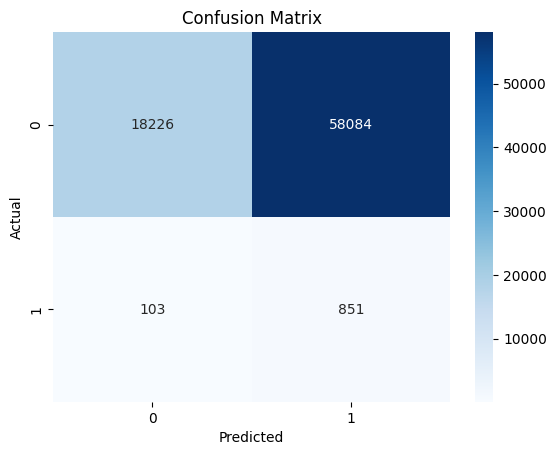

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [106]:
TN, FP, FN, TP = cm.ravel()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.0144
Recall:    0.8920
F1-score:  0.0284


In [107]:
##--Calculate ROC-AUC Score--##
from sklearn.metrics import roc_auc_score
y_true = g.ndata['y'][test_mask].cpu().numpy()
y_scores = (all_preds).numpy()
roc_auc = roc_auc_score(y_true, y_scores)  # Assuming class 1 is the positive class
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.5654


In [108]:


test_df = pd.DataFrame()
test_df['node_index'] = idx_te
test_df['true_label'] = y_true
test_df['predicted_label'] = y_scores
test_df.head()

test_df[(test_df['predicted_label']==1 )& (test_df['true_label']==1)]

,node_index,true_label,predicted_label
72,510918,1,1
189,220855,1,1
233,463652,1,1
236,318427,1,1
288,349043,1,1
...,...,...,...
57368,453180,1,1
57449,69661,1,1
57485,115246,1,1
57506,367495,1,1


In [116]:
np.arange(g.num_nodes())

array([     0,      1,      2, ..., 515085, 515086, 515087])

In [112]:
g.ndata['node_id'][453180]

tensor(453180)

# 3️⃣ Graph Explainer

In [62]:
from dgl.nn.pytorch.explain import GNNExplainer

In [65]:
# --- wrapper that gives a full-graph forward for explaining ---

class SAGEFull(nn.Module):
    def __init__(self, trained_sage):
        super().__init__()
        self.conv1 = trained_sage.conv1
        self.conv2 = trained_sage.conv2
        self.dropout = trained_sage.dropout

    # Accept both positional and keyword calls from the explainer
    def forward(self, graph=None, feat=None, x=None, **kwargs):
        # DGL explainers may send feat as 'feat=' or you might pass 'x='
        if feat is None:
            feat = x
        g = graph
        h = self.conv1(g, feat)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(g, h)
        return h


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = g.to(device)
feat = g.ndata['X'].to(device)


expl_model = SAGEFull(model).to(device)
expl_model.eval()

# Instantiate explainer
explainer = GNNExplainer(
    expl_model,
    num_hops=2,           # = number of message-passing layers
    lr=0.01,
    num_epochs=200,       # you can raise this if masks look noisy
    log=True
)




  0%|          | 0/200 [00:00<?, ?it/s]

Top-10 important features for predicted class: 1
amount_received_1: 0.156
amount_paid_5: 0.156
amount_paid_0: 0.155
amount_paid_13: 0.155
amount_received_8: 0.154
amount_paid_4: 0.153
amount_paid_1: 0.152
amount_received_14: 0.150
amount_paid_10: 0.146
amount_received_9: 0.145
Unique labels in subgraph: tensor([0, 1])


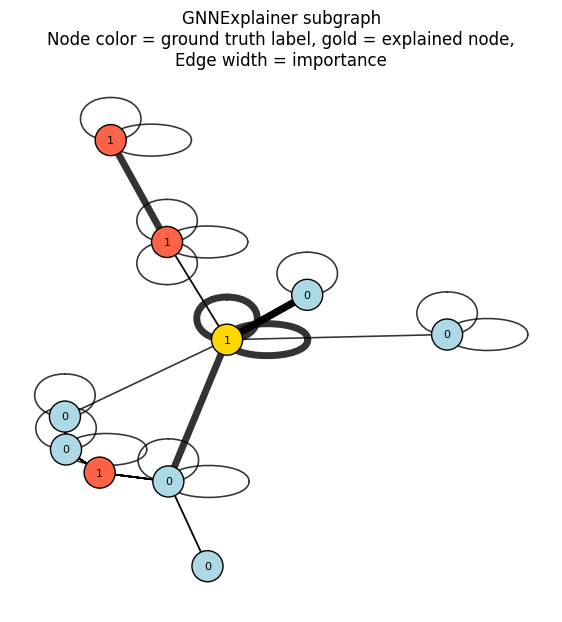

In [164]:
import torch
import dgl
import networkx as nx
import matplotlib.pyplot as plt

# -------- Choose node to explain --------
node_id = 220274

# -------- Get model prediction for that node (optional, for target class) --------
with torch.no_grad():
    expl_model.eval()  # make sure dropout etc. are off
    logits_full = expl_model(graph=g.to(g.device), feat=feat.to(g.device))
    pred_class = logits_full[node_id].argmax().item()

# -------- Run GNNExplainer on that node --------
new_center, sg, node_feat_mask, edge_mask = explainer.explain_node(
    node_id,
    g.to(g.device),
    feat.to(g.device),
    target=pred_class
)

# -------- Top-k important features --------
print("Top-10 important features for predicted class:", pred_class)
feature_names = list(node_features.columns)  # pandas DataFrame columns assumed
topk_vals, topk_idx = torch.topk(node_feat_mask.detach().cpu().flatten(), k=10)
for val, idx in zip(topk_vals.tolist(), topk_idx.tolist()):
    print(f"{feature_names[idx]}: {val:.3f}")

# ======================================================
# ===== Visualization of the subgraph with labels ======
# ======================================================

# ----- Prepare edge importance for thickness -----
edge_importance = edge_mask.detach().cpu()

# normalize 0-1 for visual scaling
edge_importance = (edge_importance - edge_importance.min()) / (
    edge_importance.max() - edge_importance.min() + 1e-9
)

# Convert sg to networkx
nx_g = dgl.to_networkx(sg.cpu()).to_undirected()

# DGL edges in sg: (u[i], v[i]) for i in range(sg.num_edges())
src, dst = sg.edges()
src = src.cpu().numpy()
dst = dst.cpu().numpy()

# Build dict: (u,v) -> importance score
edge_imp_lookup = {}
for i, (u, v) in enumerate(zip(src, dst)):
    key = tuple(sorted((int(u), int(v))))  # undirected key
    edge_imp_lookup[key] = float(edge_importance[i])

# Build edge width list in NetworkX edge order
widths = []
for u, v in nx_g.edges():
    key = tuple(sorted((u, v)))
    w = edge_imp_lookup.get(key, 0.01)
    widths.append(1.0 + 4.0 * w)  # scale thickness

# ----- Get ground-truth labels for each node in sg -----
# sg is relabeled 0..sg.num_nodes()-1, but retains original node IDs in dgl.NID
orig_nids = sg.ndata[dgl.NID]                  # map sg node idx -> original g node idx
y_sub = g.ndata['y'][orig_nids].cpu()          # ground truth label for each sg node

# Optional: sanity check
print("Unique labels in subgraph:", y_sub.unique())

# ----- Build node colors from labels -----
# you define how to color each class:
label_to_color = {
    0: "lightblue",   # non-laundering class
    1: "tomato",      # laundering class
}

node_colors = []
for local_idx in nx_g.nodes():
    # local_idx is sg's node index (0 .. sg.num_nodes()-1)
    gt_label = int(y_sub[local_idx].item())
    color = label_to_color.get(gt_label, "gray")

    # highlight the explained node (center of explanation) specially
    if local_idx == new_center:
        color = "gold"

    node_colors.append(color)

# ----- Build node text labels (so we can display their ground truth class) -----
node_labels = {
    local_idx: str(int(y_sub[local_idx].item()))
    for local_idx in nx_g.nodes()
}

# ----- Draw -----
plt.figure(figsize=(7,7))
pos = nx.spring_layout(nx_g, seed=42)  # layout for consistent plotting

# draw nodes
nx.draw_networkx_nodes(
    nx_g,
    pos,
    node_color=node_colors,
    node_size=500,
    linewidths=1,
    edgecolors='black'
)

# draw edges with thickness from importance
nx.draw_networkx_edges(
    nx_g,
    pos,
    width=widths,
    alpha=0.8
)

# draw node labels (ground truth class)
nx.draw_networkx_labels(
    nx_g,
    pos,
    labels=node_labels,
    font_size=8,
    font_color='black'
)

plt.axis('off')
plt.title("GNNExplainer subgraph\nNode color = ground truth label, gold = explained node,\nEdge width = importance")
plt.show()


In [158]:
orig_nids = sg.ndata[dgl.NID]    # shape [sg.num_nodes()]
y_full = g.ndata['y']            # labels for ALL nodes in the big graph
y_sub = y_full[orig_nids]        # labels for just sg's nodes
print(y_sub)                     # tensor([...])


tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


In [159]:
orig_nids

tensor([    93,  81521,  98537, 200978, 220274, 281990, 302221, 332391, 380300,
        382559, 382686, 382721, 382751, 382825, 382837, 382842, 382907, 382911,
        383004, 384158, 384170, 384250, 384296, 384401, 384894, 385140, 385293,
        385408, 385640, 385690, 385841, 385869, 385891, 386461, 386462, 386464,
        387016, 387658, 387772, 388611, 389008, 389019, 389388, 389439, 433894,
        433933, 433971, 466081, 511865, 511970, 514375, 514397, 514414, 514564,
        514750, 514800, 514972, 515025, 515061, 515066, 515076])

In [145]:
# expl_model is the wrapper model you used for explainer, in eval mode
sg = sg.to(device)
with torch.no_grad():
    logits_sub = expl_model(graph=sg, feat=feat[orig_nids.to(device)])
    pred_sub = logits_sub.argmax(dim=1).cpu()  # predicted class per node in sg

print("Predicted class per sg node:", pred_sub.tolist())
print("True label per sg node:    ", y_sub.tolist())
print("Center node predicted / true:",
      pred_sub[new_center].item(),
      y_sub[new_center].item())


Predicted class per sg node: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
True label per sg node:     [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Center node predicted / true: 1 1


In [146]:
node_label_df[node_label_df['label']==node_id]

,account,label,is_laundering
150489,0010057_803DE1580,93,1.0


In [151]:
trans_df[trans_df['to_account']==node_id]

,transaction_id,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
213808,213808,0.000039,0010057,93,0010057,93,1109.99,13,1109.99,13,5,0
317700,317700,0.177704,014290,220274,0010057,93,6407.28,13,6407.28,13,0,0
317701,317701,0.177704,014290,220274,0010057,93,892031.21,13,892031.21,13,0,1
317702,317702,0.192631,0010057,93,0010057,93,11364.12,0,847804.86,13,0,0
556403,556403,0.017440,070,515076,0010057,93,36844.02,13,36844.02,13,3,0
556404,556404,0.016537,070,515076,0010057,93,17.00,13,17.00,13,4,0
556405,556405,0.016537,070,515076,0010057,93,1.63,13,1.63,13,2,0
907798,907798,0.042226,0010057,93,0010057,93,2169333.34,13,2169333.34,13,5,0
1372581,1372581,0.074593,029467,380300,0010057,93,349546.67,13,349546.67,13,3,0
1372582,1372582,0.074279,029467,380300,0010057,93,978393.18,13,978393.18,13,4,0


In [149]:
trans_df.head()

,transaction_id,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,0,0.000786,010,132152,010,132152,3697.34,12,3697.34,12,5,0
1,1,0.000786,03208,417156,001,39897,0.01,12,0.01,12,3,0
2,2,0.000000,03209,417458,03209,417458,14675.57,12,14675.57,12,5,0
3,3,0.000079,012,192342,012,192342,2806.97,12,2806.97,12,5,0
4,4,0.000236,010,132160,010,132160,36682.97,12,36682.97,12,5,0


In [142]:
prediction_on_full_df = pd.DataFrame()
prediction_on_full_df['prediction'] = logits.argmax(dim=1)
prediction_on_full_df['ground_truth'] = g.ndata['y']
prediction_on_full_df['index'] = prediction_on_full_df.index
c1 = prediction_on_full_df['prediction']  == 1
c2 = prediction_on_full_df['ground_truth']  == 1
prediction_on_full_df[c1&c2]

,prediction,ground_truth,index
93,1,1,93
140,1,1,140
175,1,1,175
188,1,1,188
238,1,1,238
...,...,...,...
515083,1,1,515083
515084,1,1,515084
515085,1,1,515085
515086,1,1,515086
